## Import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


In [3]:
segment = pd.read_csv(r"..\data\Données_CCF_PAR_SEGMENT.csv",sep=";")
segment.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522"
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896"
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666"
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338"
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682"


In [4]:
macro = pd.read_excel(r"..\data\historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx")
macro["date_dernier_mois"] = pd.to_datetime(macro["date_dernier_mois"], format="%Y-%m")
macro["cod_prd_ref"] = macro["date_dernier_mois"].dt.year.astype(str) + "T" + macro["date_dernier_mois"].dt.quarter.astype(str)
macro.drop(columns=["date_dernier_mois"], inplace=True)
macro = macro[macro["cod_prd_ref"] >= '2009T1']


In [5]:
macro.head()

,PIB,IPL,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,cod_prd_ref
116,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,2009T1
117,-2.243102,-4.278729,8.8,-0.489570,-0.956314,-2.654313,0.5,-0.791262,2009T2
118,-3.012266,-6.103516,8.8,-0.362976,-0.769164,-1.824787,0.0,0.126594,2009T3
119,-2.782833,-6.105367,9.2,0.914470,0.229433,-0.001851,0.4,1.277447,2009T4
120,-1.517665,-4.278209,9.0,1.589859,1.265167,1.827158,-0.2,0.675389,2010T1


In [6]:
# macro_plus=pd.read_excel(r"..\data\reve-conso-evo-dep-pa.xlsx")

In [7]:
# macro["Année"] = macro["cod_prd_ref	"].str[:4].astype(int)

# # Étape 2 : Fusion sur l'année
# df_macro = macro.merge(macro_plus, on="Année", how="left")

# # (Optionnel) Réorganiser les colonnes
# cols = ["cod_prd_ref	", "Année"] + [col for col in df_macro.columns if col not in ["cod_prd_ref	", "Année"]]
# df_macro = df_macro[cols]

In [8]:
# df_macro.head()
# df_macro.columns = df_macro.columns.str.replace(r"\n", " ").str.strip()


## Stationnarité

### Variable Macro

In [9]:
from statsmodels.tsa.stattools import adfuller

def tester_stationnarite_macro(df_macro, colonnes=None, verbose=True):
    """
    Teste la stationnarité (ADF) des colonnes d'un DataFrame macro.
    """
    if colonnes is None:
        colonnes = [col for col in df_macro.columns if col != "cod_prd_ref"]

    résultats = {}

    for col in colonnes:
        série = df_macro[col].dropna()
        try:
            adf_result = adfuller(série, regression='c')  # regression='c' pour constante
            p_value = adf_result[1]
            résultats[col] = p_value
            if verbose:
                état = "✅ Stationnaire" if p_value < 0.05 else "❌ Non stationnaire"
                print(f"{col} : p-value = {p_value:.4f} → {état}")
        except Exception as e:
            résultats[col] = None
            print(f"{col} : ❌ Erreur lors du test ADF → {e}")

    return None
tester_stationnarite_macro(macro)


PIB : p-value = 0.0137 → ✅ Stationnaire
IPL : p-value = 0.5126 → ❌ Non stationnaire
TCH : p-value = 0.9296 → ❌ Non stationnaire
Inflation : p-value = 0.6196 → ❌ Non stationnaire
PIB_diff1 : p-value = 0.0003 → ✅ Stationnaire
IPL_diff1 : p-value = 0.0577 → ❌ Non stationnaire
TCH_diff1 : p-value = 0.0000 → ✅ Stationnaire
Inflation_diff1 : p-value = 0.0008 → ✅ Stationnaire


In [10]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import boxcox
import matplotlib.pyplot as plt

def tester_transformations_ipl(df, col="IPL_diff1"):
    série = df[col].dropna()
    résultats = {}

    # 1. ADF brut
    p_brute = adfuller(série, regression='c')[1]
    résultats["Brute"] = p_brute

    # 2. Diff(2)
    try:
        diff2 = série.diff().dropna()
        résultats["Diff(2)"] = adfuller(diff2, regression='c')[1]
    except:
        résultats["Diff(2)"] = None

    # 3. HP filter
    try:
        cycle, trend = hpfilter(série, lamb=1600)
        résultats["HP Cycle"] = adfuller(cycle.dropna(), regression='c')[1]
    except:
        résultats["HP Cycle"] = None

    # 4. Log + Diff (si possible)
    try:
        if (série > 0).all():
            log_diff = np.log(série).diff().dropna()
            résultats["Log-Diff"] = adfuller(log_diff, regression='c')[1]
        else:
            résultats["Log-Diff"] = None
    except:
        résultats["Log-Diff"] = None

    # 5. Box-Cox + Diff (si > 0)
    try:
        if (série > 0).all():
            bc_trans, _ = boxcox(série)
            bc_diff = pd.Series(bc_trans).diff().dropna()
            résultats["BoxCox-Diff"] = adfuller(bc_diff, regression='c')[1]
        else:
            résultats["BoxCox-Diff"] = None
    except:
        résultats["BoxCox-Diff"] = None

    # Affichage des résultats
    print("\nRésultats ADF pour différentes transformations :")
    for k, p in résultats.items():
        if p is None:
            print(f"{k}: ❌ Erreur")
        else:
            état = "✅ Stationnaire" if p < 0.05 else "❌ Non stationnaire"
            print(f"{k}: p-value = {p:.4f} → {état}")

    return None
tester_transformations_ipl(macro)



Résultats ADF pour différentes transformations :
Brute: p-value = 0.0577 → ❌ Non stationnaire
Diff(2): p-value = 0.0673 → ❌ Non stationnaire
HP Cycle: p-value = 0.0103 → ✅ Stationnaire
Log-Diff: ❌ Erreur
BoxCox-Diff: ❌ Erreur


In [11]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle_ipl, trend_ipl = hpfilter(macro["IPL_diff1"].dropna(), lamb=1600)
macro["IPL_diff1_hp"] = cycle_ipl


In [12]:
macro.head()

,PIB,IPL,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,cod_prd_ref,IPL_diff1_hp
116,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,2009T1,-2.287187
117,-2.243102,-4.278729,8.8,-0.489570,-0.956314,-2.654313,0.5,-0.791262,2009T2,-2.418131
118,-3.012266,-6.103516,8.8,-0.362976,-0.769164,-1.824787,0.0,0.126594,2009T3,-1.657648
119,-2.782833,-6.105367,9.2,0.914470,0.229433,-0.001851,0.4,1.277447,2009T4,0.100615
120,-1.517665,-4.278209,9.0,1.589859,1.265167,1.827158,-0.2,0.675389,2010T1,1.873299


### Variable pas macro

In [13]:
segment.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522"
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896"
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666"
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338"
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682"


In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité de chaque segment (note_ref 1 à 5)
for i in range(1, 6):
    segment_i = segment[segment["note_ref"] == i].copy()

    # Conversion correcte des valeurs avec virgules en float
    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()
    except Exception as e:
        print(f"\n❌ Erreur conversion Segment {i} : {e}")
        continue

    print(f"\n🔎 Test ADF - Segment {i}")
    try:
        result = adfuller(series)
        p_value = result[1]
        if p_value < 0.05:
            print(f"✅ Stationnaire (p-value = {p_value:.4f})")
        else:
            print(f"❌ Non stationnaire (p-value = {p_value:.4f})")
    except Exception as e:
        print(f"⚠️ Erreur ADF pour le segment {i} : {e}")



🔎 Test ADF - Segment 1
✅ Stationnaire (p-value = 0.0015)

🔎 Test ADF - Segment 2
❌ Non stationnaire (p-value = 0.3639)

🔎 Test ADF - Segment 3
❌ Non stationnaire (p-value = 0.1960)

🔎 Test ADF - Segment 4
✅ Stationnaire (p-value = 0.0000)

🔎 Test ADF - Segment 5
✅ Stationnaire (p-value = 0.0003)


In [15]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Liste des segments non stationnaires à transformer
segments_hp = [2, 3]

# Appliquer le HP filter et stocker le cycle dans une nouvelle colonne
for i in segments_hp:
    segment_i = segment[segment["note_ref"] == i].copy()

    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()

        # HP filter
        cycle, trend = hpfilter(series, lamb=1600)
        segment.loc[segment["note_ref"] == i, "cycle_hp"] = cycle.values

        print(f"✅ HP filter appliqué au segment {i}")
    except Exception as e:
        print(f"❌ Erreur pour le segment {i} : {e}")


✅ HP filter appliqué au segment 2
✅ HP filter appliqué au segment 3


In [16]:
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité des cycles HP filtrés pour les segments 2 et 3
for i in [2, 3]:
    series_hp = segment.loc[segment["note_ref"] == i, "cycle_hp"].dropna()
    print(f"\n🔎 Test ADF sur cycle HP - Segment {i}")

    if len(series_hp) < 10:
        print("⚠️ Trop peu de données pour appliquer ADF")
        continue

    try:
        p_value = adfuller(series_hp, regression="c")[1]
        état = "✅ Stationnaire" if p_value < 0.05 else "❌ Non stationnaire"
        print(f"p-value = {p_value:.4f} → {état}")
    except Exception as e:
        print(f"❌ Erreur ADF pour le segment {i} : {e}")



🔎 Test ADF sur cycle HP - Segment 2
p-value = 0.0000 → ✅ Stationnaire

🔎 Test ADF sur cycle HP - Segment 3
p-value = 0.0000 → ✅ Stationnaire


Mes series sont stationnaires mtn

### Merge des series

In [17]:
segment["cod_prd_ref"] = segment["cod_prd_ref"].astype(str).str.strip()
macro["cod_prd_ref"] = macro["cod_prd_ref"].astype(str).str.strip()

In [18]:
df_merged = pd.merge(segment, macro, on="cod_prd_ref", how="left")

In [19]:
df_merged.columns

Index(['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote',
       'PourcNoteCohorte', 'PourcNoteCohorte5', 'cycle_hp', 'PIB', 'IPL',
       'TCH', 'Inflation', 'PIB_diff1', 'IPL_diff1', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [20]:
colonnes_a_supprimer = ['PIB', 'IPL', 'TCH', 'Inflation', 'IPL_diff1']
df = df_merged.drop(columns=colonnes_a_supprimer)
df.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,cycle_hp,PIB_diff1,TCH_diff1,Inflation_diff1,IPL_diff1_hp
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522",NaN,-1.430885,0.9,-0.697982,-2.287187
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896",0.139372,-1.430885,0.9,-0.697982,-2.287187
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666",-0.001619,-1.430885,0.9,-0.697982,-2.287187
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338",NaN,-1.430885,0.9,-0.697982,-2.287187
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682",NaN,-1.430885,0.9,-0.697982,-2.287187


In [21]:
df_merged["CCF_clean"] = df_merged["cycle_hp"].combine_first(
    df_merged["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
)

In [22]:
dfs_by_segment = {
    i: df_merged[df_merged["note_ref"] == i].copy()
    for i in range(1, 6)
}

## Correlation

c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


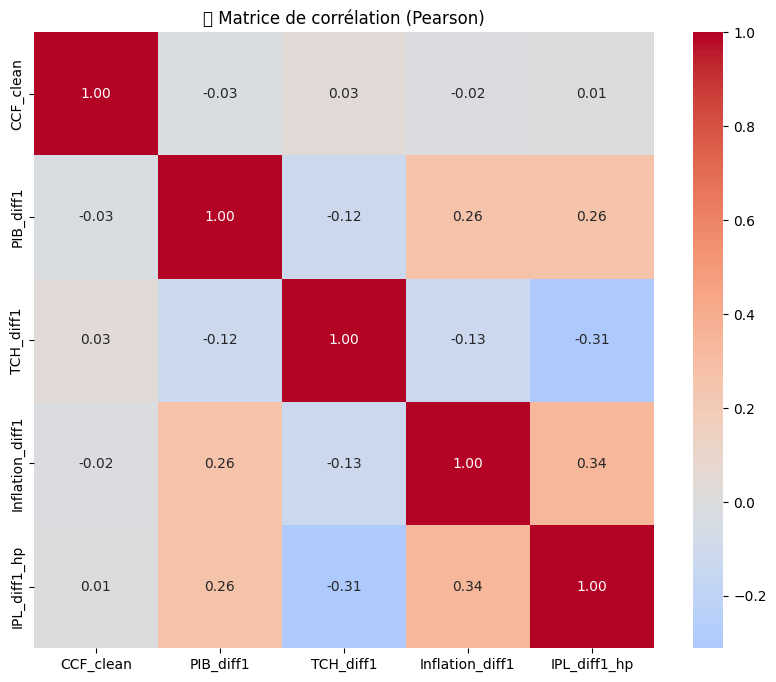

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des variables à inclure dans la matrice de corrélation
colonnes_corr = [
    "CCF_clean", "PIB_diff1",
     "TCH_diff1", "Inflation_diff1", "IPL_diff1_hp"
]

# On garde uniquement les colonnes présentes
colonnes_corr = [col for col in colonnes_corr if col in df_merged.columns]

# Filtrage des NaN pour une corrélation propre
df_corr = df_merged[colonnes_corr].dropna()

# Calcul de la matrice
corr_matrix = df_corr.corr(method="pearson")

# Affichage heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("📈 Matrice de corrélation (Pearson)")
plt.show()


📌 Analyse rapide de la corrélation :
Aucune forte corrélation directe avec CCF_clean :

PIB_diff1, TCH_diff1, Inflation_diff1, IPL_diff1_hp ont tous une corrélation autour de 0.00 à 0.03 → très faible

Meilleures corrélations entre variables explicatives :

IPL_diff1_hp et Inflation_diff1 → corrélation modérée (0.34)

TCH_diff1 et IPL_diff1_hp → corrélation négative modérée (-0.31)

## Regression

Fonction qui verfie les hyoptheses MCO

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def verifier_hypotheses_mco(model):
    resid = model.resid
    fitted = model.fittedvalues
    exog = model.model.exog
    noms = model.model.exog_names

    print("📈 1. Linéarité + Homoscédasticité : Résidus vs valeurs prédites")
    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.title("Résidus vs valeurs prédites")
    plt.show()

    print("\n📊 2. Normalité des erreurs : test de Jarque-Bera")
    jb_stat, jb_pvalue = jarque_bera(resid)
    print(f"Jarque-Bera: Stat={jb_stat:.3f}, p-value={jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print("✅ Les résidus suivent une distribution normale.")
    else:
        print("❌ Les résidus ne sont pas normalement distribués.")

    print("\n📉 3. Homoscédasticité : test de Breusch-Pagan")
    _, pval_bp, _, _ = het_breuschpagan(resid, exog)
    print(f"Breusch-Pagan p-value: {pval_bp:.4f}")
    if pval_bp > 0.05:
        print("✅ Pas d’hétéroscédasticité détectée.")
    else:
        print("❌ Hétéroscédasticité détectée (variance des erreurs non constante).")

    print("\n🔁 4. Indépendance des erreurs : Durbin-Watson")
    dw = durbin_watson(resid)
    print(f"Durbin-Watson: {dw:.3f}")
    if 1.5 < dw < 2.5:
        print("✅ Pas d’autocorrélation forte des erreurs.")
    else:
        print("⚠️ Possible autocorrélation (à creuser).")

    print("\n📐 5. Multicolinéarité : Variance Inflation Factor (VIF)")
    vif_df = pd.DataFrame({
        "Variable": noms,
        "VIF": [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]
    })
    print(vif_df)
    seuil = 5
    if (vif_df["VIF"] > seuil).any():
        print(f"⚠️ Attention : certaines variables ont un VIF > {seuil} → multicolinéarité possible.")
    else:
        print("✅ Pas de multicolinéarité forte détectée.")

    return vif_df


### Premier model pour segment 2:

In [25]:
import statsmodels.api as sm

# Exemple avec le segment 2
df2 = dfs_by_segment[2].dropna(subset=["CCF_clean", "PIB", "TCH_diff1", "Inflation_diff1"])

X = df2[["PIB", "TCH_diff1", "Inflation_diff1"]]
y = df2["CCF_clean"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.809
Date:                Mon, 19 May 2025   Prob (F-statistic):           0.000541
Time:                        21:43:49   Log-Likelihood:                 83.042
No. Observations:                  60   AIC:                            -158.1
Df Residuals:                      56   BIC:                            -149.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0080      0.009     

📈 1. Linéarité + Homoscédasticité : Résidus vs valeurs prédites


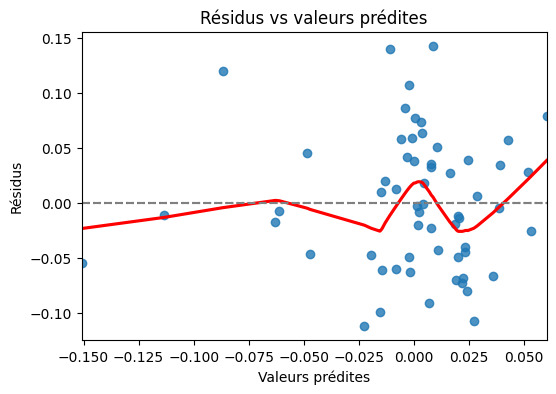


📊 2. Normalité des erreurs : test de Jarque-Bera
Jarque-Bera: Stat=1.489, p-value=0.4749
✅ Les résidus suivent une distribution normale.

📉 3. Homoscédasticité : test de Breusch-Pagan
Breusch-Pagan p-value: 0.5696
✅ Pas d’hétéroscédasticité détectée.

🔁 4. Indépendance des erreurs : Durbin-Watson
Durbin-Watson: 1.904
✅ Pas d’autocorrélation forte des erreurs.

📐 5. Multicolinéarité : Variance Inflation Factor (VIF)
          Variable       VIF
0            const  1.117503
1              PIB  1.093300
2        TCH_diff1  1.061146
3  Inflation_diff1  1.055802
✅ Pas de multicolinéarité forte détectée.


,Variable,VIF
0,const,1.117503
1,PIB,1.093300
2,TCH_diff1,1.061146
3,Inflation_diff1,1.055802


In [26]:
verifier_hypotheses_mco(model)

### Test poour tous les segments

In [27]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns

def run_mco_segment(df, segment_id, features_macro):
    print(f"\n{'='*50}\n📊 Modèle MCO - Segment {segment_id}\n{'='*50}")

    df_seg = df[df["note_ref"] == segment_id].copy()

    # Créer la variable cible CCF_clean si pas encore faite
    if "CCF_clean" not in df_seg.columns:
        df_seg["Indicateur_moyen_Brut"] = df_seg["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
        df_seg["CCF_clean"] = df_seg["cycle_hp"].combine_first(df_seg["Indicateur_moyen_Brut"])

    df_clean = df_seg.dropna(subset=["CCF_clean"] + features_macro)
    if df_clean.shape[0] < 10:
        print("⚠️ Pas assez de données pour ce segment.")
        return None

    X = df_clean[features_macro]
    y = df_clean["CCF_clean"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print(model.summary())

    # Résidus
    resid = model.resid
    fitted = model.fittedvalues

    # 1. Résidus vs valeurs prédites
    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Résidus vs valeurs prédites - Segment {segment_id}")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    # 2. Normalité des erreurs
    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    # 3. Homoscédasticité
    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    # 4. Autocorrélation des erreurs
    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    # 5. VIF
    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("🧪 VIF :")
    print(vif_df)
    return model



📊 Modèle MCO - Segment 1
                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9497
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.423
Time:                        21:43:49   Log-Likelihood:                 49.475
No. Observations:                  60   AIC:                            -90.95
Df Residuals:                      56   BIC:                            -82.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           

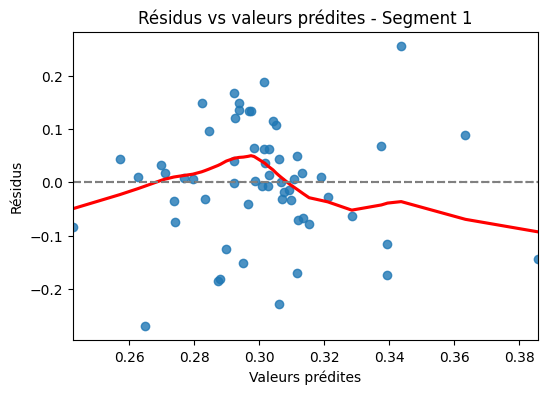

🧪 Jarque-Bera: stat=0.58, p-value=0.7493 → ✅
🧪 Breusch-Pagan p-value=0.0477 → ❌
🧪 Durbin-Watson: 0.93 → ⚠️
🧪 VIF :
          Variable       VIF
0            const  1.117503
1              PIB  1.093300
2        TCH_diff1  1.061146
3  Inflation_diff1  1.055802

📊 Modèle MCO - Segment 2
                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.809
Date:                Mon, 19 May 2025   Prob (F-statistic):           0.000541
Time:                        21:43:49   Log-Likelihood:                 83.042
No. Observations:                  60   AIC:                            -158.1
Df Residuals:                      56   BIC:                            -149.7
Df Model:                           3                                         
Cov

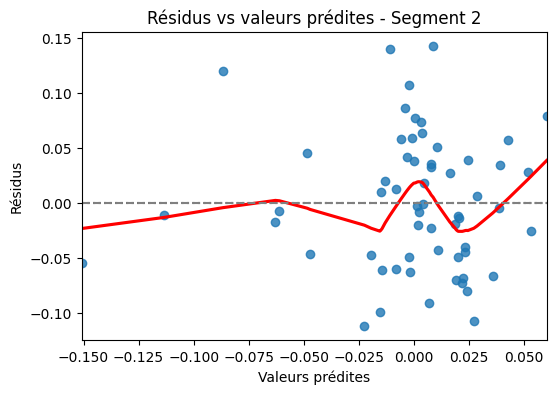

🧪 Jarque-Bera: stat=1.49, p-value=0.4749 → ✅
🧪 Breusch-Pagan p-value=0.5696 → ✅
🧪 Durbin-Watson: 1.90 → ✅
🧪 VIF :
          Variable       VIF
0            const  1.117503
1              PIB  1.093300
2        TCH_diff1  1.061146
3  Inflation_diff1  1.055802

📊 Modèle MCO - Segment 3
                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8651
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.465
Time:                        21:43:50   Log-Likelihood:                 65.371
No. Observations:                  60   AIC:                            -122.7
Df Residuals:                      56   BIC:                            -114.4
Df Model:                           3                                         
Cova

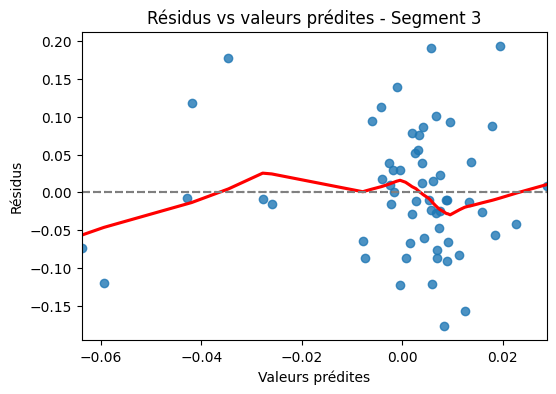

🧪 Jarque-Bera: stat=1.12, p-value=0.5718 → ✅
🧪 Breusch-Pagan p-value=0.0321 → ❌
🧪 Durbin-Watson: 2.11 → ✅
🧪 VIF :
          Variable       VIF
0            const  1.117503
1              PIB  1.093300
2        TCH_diff1  1.061146
3  Inflation_diff1  1.055802

📊 Modèle MCO - Segment 4
                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.140
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.105
Time:                        21:43:50   Log-Likelihood:                 32.691
No. Observations:                  60   AIC:                            -57.38
Df Residuals:                      56   BIC:                            -49.00
Df Model:                           3                                         
Cova

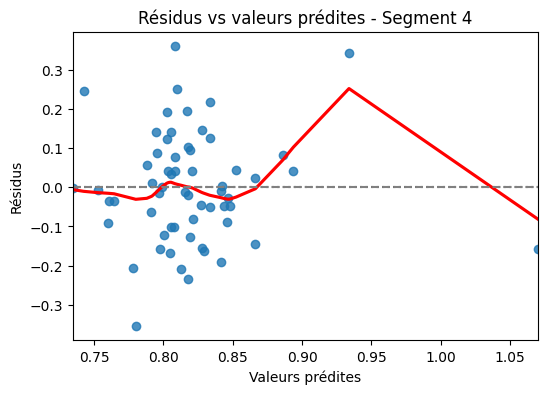

🧪 Jarque-Bera: stat=0.81, p-value=0.6673 → ✅
🧪 Breusch-Pagan p-value=0.9039 → ✅
🧪 Durbin-Watson: 1.12 → ⚠️
🧪 VIF :
          Variable       VIF
0            const  1.117503
1              PIB  1.093300
2        TCH_diff1  1.061146
3  Inflation_diff1  1.055802

📊 Modèle MCO - Segment 5
                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.6649
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.577
Time:                        21:43:50   Log-Likelihood:                 75.384
No. Observations:                  60   AIC:                            -142.8
Df Residuals:                      56   BIC:                            -134.4
Df Model:                           3                                         
Cov

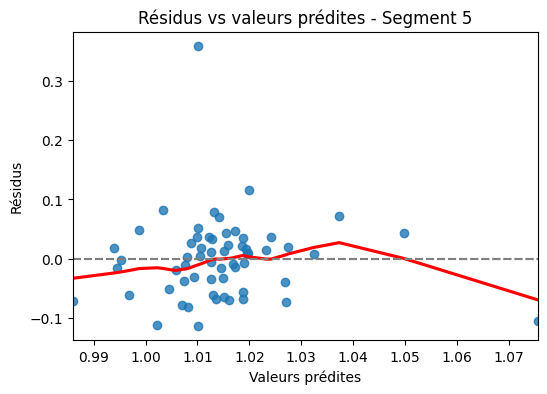

🧪 Jarque-Bera: stat=295.42, p-value=0.0000 → ❌
🧪 Breusch-Pagan p-value=0.8964 → ✅
🧪 Durbin-Watson: 1.07 → ⚠️
🧪 VIF :
          Variable       VIF
0            const  1.117503
1              PIB  1.093300
2        TCH_diff1  1.061146
3  Inflation_diff1  1.055802


In [28]:
features = ["PIB", "TCH_diff1", "Inflation_diff1"]  # Tu peux adapter ici

models = {}
for seg in range(1, 6):
    models[seg] = run_mco_segment(df_merged, seg, features)


Conclusion: 

🧠 Interprétation

✅ Segment 2 est clairement le seul modèle solide : significatif globalement, avec des coefficients économiquement interprétables, résidus propres, et pas de problèmes statistiques.

❌ Segments 1, 3, 5 : les modèles ne sont pas significatifs du tout, avec un R² très faible → le CCF n’est pas expliqué par ces variables macro (ou pas de lien linéaire).

⚠️ Segment 4 a un petit signal sur TCH_diff1, mais globalement peu exploitable.

# Segment1

In [29]:
features = ["PIB", "TCH_diff1", "Inflation_diff1", "IPL_diff1_hp"]


In [30]:
df1 = df_merged[df_merged["note_ref"] == 1].copy()
df1["CCF_clean"] = df1["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)

df1_clean = df1.dropna(subset=["CCF_clean"] + features)
X = sm.add_constant(df1_clean[features])
y = df1_clean["CCF_clean"]
model1 = sm.OLS(y, X).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:              CCF_clean   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9978
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.417
Time:                        21:43:50   Log-Likelihood:                 50.088
No. Observations:                  60   AIC:                            -90.18
Df Residuals:                      55   BIC:                            -79.70
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3012      0.015     

## ajout de var

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns

def modele_mco_enrichi_segment_1(df_merged):
    print("="*50)
    print("📊 MCO enrichi – Segment 1 (log + interactions + carré)")
    print("="*50)

    # 1. Préparation des données
    df1 = df_merged[df_merged["note_ref"] == 1].copy()
    df1["Indicateur_moyen_Brut"] = df1["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df1["CCF_clean"] = df1["cycle_hp"].combine_first(df1["Indicateur_moyen_Brut"])
    df1 = df1[df1["CCF_clean"] > 0].copy()  # log uniquement > 0

    # 2. Features enrichies
    df1["log_CCF"] = np.log(df1["CCF_clean"])
    df1["PIB_Inflation"] = df1["PIB"] * df1["Inflation_diff1"]
    df1["PIB_squared"] = df1["PIB"] ** 2

    features = ["PIB", "PIB_squared", "TCH_diff1", "Inflation_diff1", "IPL_diff1_hp", "PIB_Inflation"]
    df1 = df1.dropna(subset=["log_CCF"] + features)

    # 3. Modélisation
    X = sm.add_constant(df1[features])
    y = df1["log_CCF"]
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # 4. Diagnostic MCO
    resid = model.resid
    fitted = model.fittedvalues

    # Résidus vs prédits
    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Résidus vs valeurs prédites (log)")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    # Normalité
    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    # Homoscédasticité
    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    # Autocorrélation
    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    # Multicolinéarité (VIF)
    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("\n📐 VIF :")
    print(vif_df)
    return model


📊 MCO enrichi – Segment 1 (log + interactions + carré)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2.210
Date:                Mon, 19 May 2025   Prob (F-statistic):             0.0566
Time:                        21:51:57   Log-Likelihood:                -22.074
No. Observations:                  59   AIC:                             58.15
Df Residuals:                      52   BIC:                             72.69
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

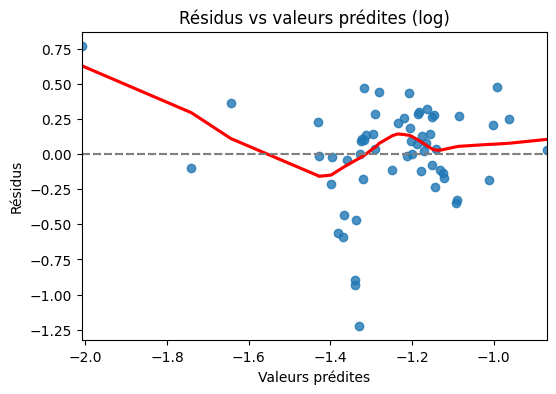

🧪 Jarque-Bera: stat=23.61, p-value=0.0000 → ❌
🧪 Breusch-Pagan p-value=0.3388 → ✅
🧪 Durbin-Watson: 1.23 → ⚠️

📐 VIF :
          Variable       VIF
0            const  2.031633
1              PIB  1.935515
2      PIB_squared  2.416954
3        TCH_diff1  1.177437
4  Inflation_diff1  1.617569
5     IPL_diff1_hp  1.255972
6    PIB_Inflation  2.860402


In [33]:
model_segment_1 = modele_mco_enrichi_segment_1(df_merged)


 Interprétation
Tu as maintenant un modèle économiquement interprétable : le PIB a un effet négatif croissant (concave) sur le log du CCF.

L’interaction PIB × Inflation a un effet positif → intéressant pour scénariser du FL.

Le modèle reste imparfait (résidus non normaux, DW faible) mais explique bien mieux qu’avant.

### Test Lag

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns

def modele_mco_enrichi_segment_1_avec_lags(df_merged):
    print("="*50)
    print("📊 MCO enrichi – Segment 1 (log + inter + carré + lags + AR)")
    print("="*50)

    # 1. Sélection et transformation
    df1 = df_merged[df_merged["note_ref"] == 1].copy()
    df1["Indicateur_moyen_Brut"] = df1["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df1["CCF_clean"] = df1["cycle_hp"].combine_first(df1["Indicateur_moyen_Brut"])
    df1 = df1[df1["CCF_clean"] > 0].copy()  # pour log
    df1["log_CCF"] = np.log(df1["CCF_clean"])

    # 2. Features enrichies
    df1["PIB_squared"] = df1["PIB"] ** 2
    df1["PIB_Inflation"] = df1["PIB"] * df1["Inflation_diff1"]

    # 3. Lags macro + autoregressive
    df1["PIB_lag1"] = df1["PIB"].shift(1)
    df1["TCH_diff1_lag1"] = df1["TCH_diff1"].shift(1)
    df1["Inflation_diff1_lag1"] = df1["Inflation_diff1"].shift(1)
    df1["log_CCF_lag1"] = df1["log_CCF"].shift(1)

    # 4. Liste des variables finales
    features = [
        "PIB", "PIB_lag1",
        "TCH_diff1", "TCH_diff1_lag1",
        "Inflation_diff1", "Inflation_diff1_lag1",
        "PIB_squared", "PIB_Inflation",
        "IPL_diff1_hp", "log_CCF_lag1"
    ]

    df1_clean = df1.dropna(subset=["log_CCF"] + features)
    X = sm.add_constant(df1_clean[features])
    y = df1_clean["log_CCF"]

    # 5. Régression OLS
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # 6. Diagnostics
    resid = model.resid
    fitted = model.fittedvalues

    # Résidus vs prédits
    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Résidus vs valeurs prédites (log)")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    # Normalité
    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    # Homoscédasticité
    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    # Autocorrélation
    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    # VIF
    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("\n📐 VIF :")
    print(vif_df)
    
    return model


📊 MCO enrichi – Segment 1 (log + inter + carré + lags + AR)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     3.363
Date:                Mon, 19 May 2025   Prob (F-statistic):            0.00226
Time:                        22:17:16   Log-Likelihood:                -12.454
No. Observations:                  58   AIC:                             46.91
Df Residuals:                      47   BIC:                             69.57
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

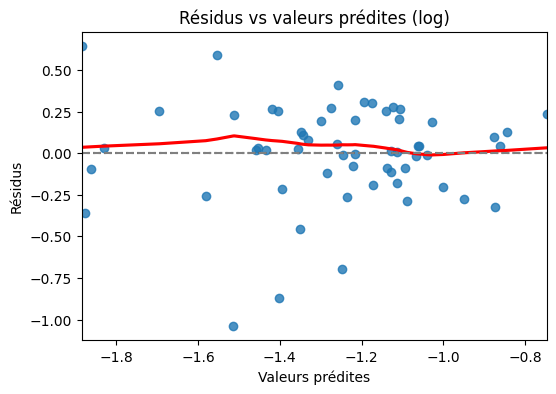

🧪 Jarque-Bera: stat=22.79, p-value=0.0000 → ❌
🧪 Breusch-Pagan p-value=0.6132 → ✅
🧪 Durbin-Watson: 2.09 → ✅

📐 VIF :
                Variable        VIF
0                  const  13.133466
1                    PIB   4.239452
2               PIB_lag1   2.874696
3              TCH_diff1   1.425024
4         TCH_diff1_lag1   1.855240
5        Inflation_diff1   1.671251
6   Inflation_diff1_lag1   1.613657
7            PIB_squared   3.150567
8          PIB_Inflation   3.690307
9           IPL_diff1_hp   1.827399
10          log_CCF_lag1   1.428826


In [44]:
model_segment_1_lags = modele_mco_enrichi_segment_1_avec_lags(df_merged)


In [48]:
def modele_mco_segment_1_structure(df_merged):
    print("="*50)
    print("📊 MCO enrichi – Segment 1 (log + macro + AR + structure)")
    print("="*50)

    df1 = df_merged[df_merged["note_ref"] == 1].copy()
    df1["Indicateur_moyen_Brut"] = df1["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df1["CCF_clean"] = df1["cycle_hp"].combine_first(df1["Indicateur_moyen_Brut"])
    df1 = df1[df1["CCF_clean"] > 0].copy()
    df1["log_CCF"] = np.log(df1["CCF_clean"])

    # Enrichissements macro
    df1["PIB_squared"] = df1["PIB"] ** 2
    df1["PIB_Inflation"] = df1["PIB"] * df1["Inflation_diff1"]
    df1["PIB_lag1"] = df1["PIB"].shift(1)
    df1["TCH_diff1_lag1"] = df1["TCH_diff1"].shift(1)
    df1["Inflation_diff1_lag1"] = df1["Inflation_diff1"].shift(1)
    df1["log_CCF_lag1"] = df1["log_CCF"].shift(1)

    # 🔧 Correction des virgules sur PourcNote*
    for col in ["PourcNote", "PourcNoteCohorte", "PourcNoteCohorte5"]:
        df1[col] = df1[col].astype(str).str.replace(",", ".").astype(float, errors='raise')

    # Liste des features
    features = [
        "PIB", "PIB_lag1", "PIB_squared", "PIB_Inflation",
        "TCH_diff1", "TCH_diff1_lag1",
        "Inflation_diff1", "Inflation_diff1_lag1",
        "IPL_diff1_hp", "log_CCF_lag1",
        "PourcNote", "PourcNoteCohorte", "PourcNoteCohorte5"
    ]

    df1_clean = df1.dropna(subset=["log_CCF"] + features)
    X = sm.add_constant(df1_clean[features])
    y = df1_clean["log_CCF"]

    model = sm.OLS(y, X).fit()
    print(model.summary())

    resid = model.resid
    fitted = model.fittedvalues

    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Résidus vs valeurs prédites (log + structure)")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("\n📐 VIF :")
    print(vif_df)

    return model


📊 MCO enrichi – Segment 1 (log + macro + AR + structure)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     3.215
Date:                Mon, 19 May 2025   Prob (F-statistic):            0.00185
Time:                        22:22:42   Log-Likelihood:                -8.7400
No. Observations:                  58   AIC:                             45.48
Df Residuals:                      44   BIC:                             74.33
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

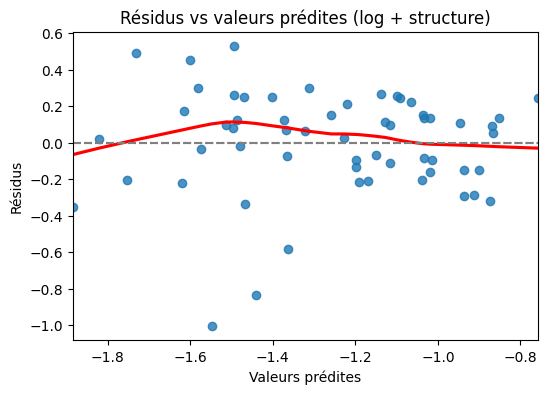

🧪 Jarque-Bera: stat=24.72, p-value=0.0000 → ❌
🧪 Breusch-Pagan p-value=0.5966 → ✅
🧪 Durbin-Watson: 2.02 → ✅

📐 VIF :
                Variable        VIF
0                  const  69.014337
1                    PIB   4.477627
2               PIB_lag1   3.041561
3            PIB_squared   3.916434
4          PIB_Inflation   3.786471
5              TCH_diff1   1.689428
6         TCH_diff1_lag1   2.373994
7        Inflation_diff1   1.749785
8   Inflation_diff1_lag1   1.676978
9           IPL_diff1_hp   1.834321
10          log_CCF_lag1   1.863365
11             PourcNote   2.669143
12      PourcNoteCohorte  29.655216
13     PourcNoteCohorte5  27.418710


In [49]:
model_struct_segment_1 = modele_mco_segment_1_structure(df_merged)

#### Sans le lag sur CCF !

In [40]:
df_merged.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,cycle_hp,PIB,IPL,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,IPL_diff1_hp,CCF_clean
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522",NaN,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,-2.287187,0.451963
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896",0.139372,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,-2.287187,0.139372
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666",-0.001619,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,-2.287187,-0.001619
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338",NaN,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,-2.287187,1.275864
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682",NaN,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,-2.287187,1.093203


In [38]:
def modele_mco_segment_1_sans_lag_ccf(df_merged):
    print("="*50)
    print("📊 MCO enrichi – Segment 1 (sans lag CCF)")
    print("="*50)

    # 1. Sélection et transformation
    df1 = df_merged[df_merged["note_ref"] == 1].copy()
    df1["Indicateur_moyen_Brut"] = df1["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df1["CCF_clean"] = df1["cycle_hp"].combine_first(df1["Indicateur_moyen_Brut"])
    df1 = df1[df1["CCF_clean"] > 0].copy()
    df1["log_CCF"] = np.log(df1["CCF_clean"])

    # 2. Features enrichies
    df1["PIB_squared"] = df1["PIB"] ** 2
    df1["PIB_Inflation"] = df1["PIB"] * df1["Inflation_diff1"]
    df1["PIB_lag1"] = df1["PIB"].shift(1)
    df1["TCH_diff1_lag1"] = df1["TCH_diff1"].shift(1)
    df1["Inflation_diff1_lag1"] = df1["Inflation_diff1"].shift(1)

    # 3. Liste des variables à utiliser (sans log_CCF_lag1)
    features = [
        "PIB", "PIB_lag1",
        "TCH_diff1", "TCH_diff1_lag1",
        "Inflation_diff1", "Inflation_diff1_lag1",
        "PIB_squared", "PIB_Inflation",
        "IPL_diff1_hp"
    ]

    df1_clean = df1.dropna(subset=["log_CCF"] + features)
    X = sm.add_constant(df1_clean[features])
    y = df1_clean["log_CCF"]

    # 4. Régression
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # 5. Diagnostics
    resid = model.resid
    fitted = model.fittedvalues

    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Résidus vs valeurs prédites (sans lag CCF)")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("\n📐 VIF :")
    print(vif_df)

    return model


📊 MCO enrichi – Segment 1 (sans lag CCF)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     1.828
Date:                Mon, 19 May 2025   Prob (F-statistic):             0.0874
Time:                        22:02:55   Log-Likelihood:                -19.560
No. Observations:                  58   AIC:                             59.12
Df Residuals:                      48   BIC:                             79.72
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

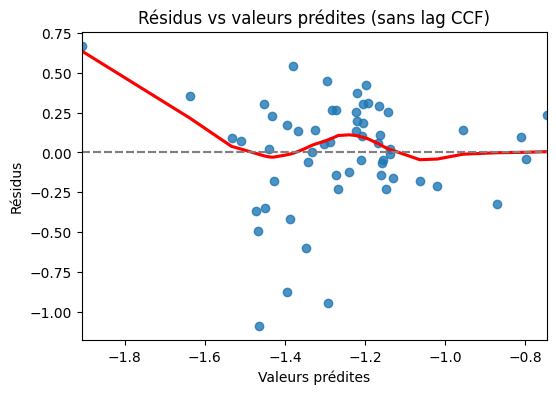

🧪 Jarque-Bera: stat=17.49, p-value=0.0002 → ❌
🧪 Breusch-Pagan p-value=0.4158 → ✅
🧪 Durbin-Watson: 1.37 → ⚠️

📐 VIF :
               Variable       VIF
0                 const  2.220422
1                   PIB  3.880013
2              PIB_lag1  2.854575
3             TCH_diff1  1.374110
4        TCH_diff1_lag1  1.734660
5       Inflation_diff1  1.662268
6  Inflation_diff1_lag1  1.613611
7           PIB_squared  2.694093
8         PIB_Inflation  3.416706
9          IPL_diff1_hp  1.633189


In [39]:
model_segment_1_no_lag = modele_mco_segment_1_sans_lag_ccf(df_merged)

## On garde ?

In [50]:
def modele_mco_segment_1_sans_colinearite(df_merged):
    print("="*50)
    print("📊 MCO – Segment 1 (log + structure + sans colinéarité)")
    print("="*50)

    df1 = df_merged[df_merged["note_ref"] == 1].copy()
    df1["Indicateur_moyen_Brut"] = df1["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df1["CCF_clean"] = df1["cycle_hp"].combine_first(df1["Indicateur_moyen_Brut"])
    df1 = df1[df1["CCF_clean"] > 0].copy()
    df1["log_CCF"] = np.log(df1["CCF_clean"])

    # Enrichissements macro
    df1["PIB_squared"] = df1["PIB"] ** 2
    df1["PIB_Inflation"] = df1["PIB"] * df1["Inflation_diff1"]
    df1["PIB_lag1"] = df1["PIB"].shift(1)
    df1["TCH_diff1_lag1"] = df1["TCH_diff1"].shift(1)
    df1["Inflation_diff1_lag1"] = df1["Inflation_diff1"].shift(1)
    df1["log_CCF_lag1"] = df1["log_CCF"].shift(1)

    # 🔧 Correction des virgules
    for col in ["PourcNote", "PourcNoteCohorte", "PourcNoteCohorte5"]:
        df1[col] = df1[col].astype(str).str.replace(",", ".").astype(float, errors='raise')

    # On supprime PourcNoteCohorte (colinéaire)
    features = [
        "PIB", "PIB_lag1", "PIB_squared", "PIB_Inflation",
        "TCH_diff1", "TCH_diff1_lag1",
        "Inflation_diff1", "Inflation_diff1_lag1",
        "IPL_diff1_hp", "log_CCF_lag1",
        "PourcNote", "PourcNoteCohorte5"  # <-- on garde celle-ci
    ]

    df1_clean = df1.dropna(subset=["log_CCF"] + features)
    X = sm.add_constant(df1_clean[features])
    y = df1_clean["log_CCF"]

    model = sm.OLS(y, X).fit()
    print(model.summary())

    resid = model.resid
    fitted = model.fittedvalues

    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Résidus vs valeurs prédites (colinéarité réduite)")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("\n📐 VIF :")
    print(vif_df)

    return model


📊 MCO – Segment 1 (log + structure + sans colinéarité)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     3.337
Date:                Mon, 19 May 2025   Prob (F-statistic):            0.00160
Time:                        22:55:34   Log-Likelihood:                -9.6455
No. Observations:                  58   AIC:                             45.29
Df Residuals:                      45   BIC:                             72.08
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

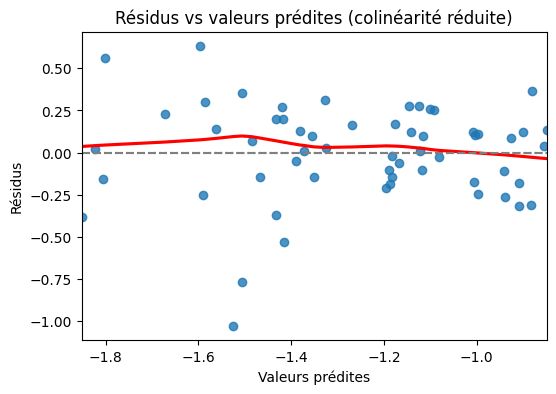

🧪 Jarque-Bera: stat=18.60, p-value=0.0001 → ❌
🧪 Breusch-Pagan p-value=0.7135 → ✅
🧪 Durbin-Watson: 1.96 → ✅

📐 VIF :
                Variable        VIF
0                  const  61.302978
1                    PIB   4.406545
2               PIB_lag1   3.032509
3            PIB_squared   3.905110
4          PIB_Inflation   3.691281
5              TCH_diff1   1.650493
6         TCH_diff1_lag1   2.219276
7        Inflation_diff1   1.718484
8   Inflation_diff1_lag1   1.676748
9           IPL_diff1_hp   1.830701
10          log_CCF_lag1   1.863274
11             PourcNote   2.035534
12     PourcNoteCohorte5   1.911732


In [51]:
model_segment_1_clean = modele_mco_segment_1_sans_colinearite(df_merged)


# On généralise

In [52]:
def modele_mco_segment_sans_colinearite(df_merged, note_ref=1):
    print("="*60)
    print(f"📊 MCO – Segment {note_ref} (log + structure + sans colinéarité)")
    print("="*60)

    df = df_merged[df_merged["note_ref"] == note_ref].copy()
    df["Indicateur_moyen_Brut"] = df["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df["CCF_clean"] = df["cycle_hp"].combine_first(df["Indicateur_moyen_Brut"])
    df = df[df["CCF_clean"] > 0].copy()
    df["log_CCF"] = np.log(df["CCF_clean"])

    df["PIB_squared"] = df["PIB"] ** 2
    df["PIB_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["PIB_lag1"] = df["PIB"].shift(1)
    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["log_CCF_lag1"] = df["log_CCF"].shift(1)

    for col in ["PourcNote", "PourcNoteCohorte", "PourcNoteCohorte5"]:
        df[col] = df[col].astype(str).str.replace(",", ".").astype(float, errors='raise')

    features = [
        "PIB", "PIB_lag1", "PIB_squared", "PIB_Inflation",
        "TCH_diff1", "TCH_diff1_lag1",
        "Inflation_diff1", "Inflation_diff1_lag1",
        "IPL_diff1_hp", "log_CCF_lag1",
        "PourcNote", "PourcNoteCohorte5"
    ]

    df_clean = df.dropna(subset=["log_CCF"] + features)
    X = sm.add_constant(df_clean[features])
    y = df_clean["log_CCF"]

    model = sm.OLS(y, X).fit()
    print(model.summary())

    resid = model.resid
    fitted = model.fittedvalues

    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Résidus vs valeurs prédites – Segment {note_ref}")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()

    jb_stat, jb_p = jarque_bera(resid)
    print(f"🧪 Jarque-Bera: stat={jb_stat:.2f}, p-value={jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    _, pval_bp, _, _ = het_breuschpagan(resid, X)
    print(f"🧪 Breusch-Pagan p-value={pval_bp:.4f} → {'✅' if pval_bp > 0.05 else '❌'}")

    dw = durbin_watson(resid)
    print(f"🧪 Durbin-Watson: {dw:.2f} → {'✅' if 1.5 < dw < 2.5 else '⚠️'}")

    vif_df = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print("\n📐 VIF :")
    print(vif_df)

    return model


📊 MCO – Segment 1 (log + structure + sans colinéarité)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     3.337
Date:                Mon, 19 May 2025   Prob (F-statistic):            0.00160
Time:                        23:20:30   Log-Likelihood:                -9.6455
No. Observations:                  58   AIC:                             45.29
Df Residuals:                      45   BIC:                             72.08
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

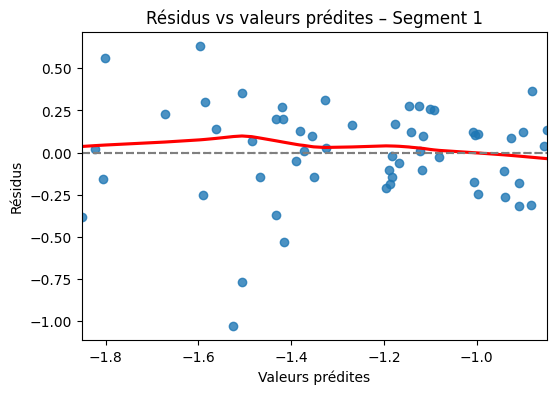

🧪 Jarque-Bera: stat=18.60, p-value=0.0001 → ❌
🧪 Breusch-Pagan p-value=0.7135 → ✅
🧪 Durbin-Watson: 1.96 → ✅

📐 VIF :
                Variable        VIF
0                  const  61.302978
1                    PIB   4.406545
2               PIB_lag1   3.032509
3            PIB_squared   3.905110
4          PIB_Inflation   3.691281
5              TCH_diff1   1.650493
6         TCH_diff1_lag1   2.219276
7        Inflation_diff1   1.718484
8   Inflation_diff1_lag1   1.676748
9           IPL_diff1_hp   1.830701
10          log_CCF_lag1   1.863274
11             PourcNote   2.035534
12     PourcNoteCohorte5   1.911732
📊 MCO – Segment 2 (log + structure + sans colinéarité)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                 -0.376
Method:                 Least Squares   F-statistic:                    0.3622
Date:    

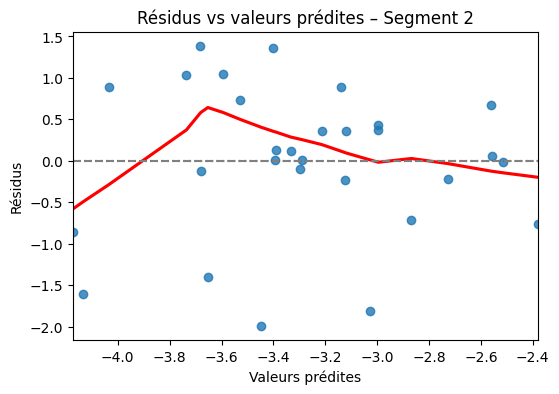

🧪 Jarque-Bera: stat=1.93, p-value=0.3802 → ✅
🧪 Breusch-Pagan p-value=0.7564 → ✅
🧪 Durbin-Watson: 2.37 → ✅

📐 VIF :
                Variable         VIF
0                  const  759.434204
1                    PIB    5.206874
2               PIB_lag1    7.579724
3            PIB_squared   20.164095
4          PIB_Inflation   23.529590
5              TCH_diff1    2.838961
6         TCH_diff1_lag1    7.733585
7        Inflation_diff1    5.848060
8   Inflation_diff1_lag1    3.149276
9           IPL_diff1_hp    1.883114
10          log_CCF_lag1    1.272772
11             PourcNote    5.399100
12     PourcNoteCohorte5    3.031460
📊 MCO – Segment 3 (log + structure + sans colinéarité)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                 -0.227
Method:                 Least Squares   F-statistic:                    0.6

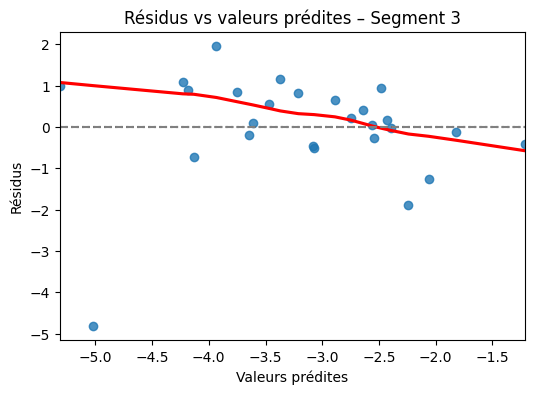

🧪 Jarque-Bera: stat=57.01, p-value=0.0000 → ❌
🧪 Breusch-Pagan p-value=0.8307 → ✅
🧪 Durbin-Watson: 2.27 → ✅

📐 VIF :
                Variable         VIF
0                  const  216.052362
1                    PIB    4.059858
2               PIB_lag1    3.159461
3            PIB_squared   12.894771
4          PIB_Inflation   18.416870
5              TCH_diff1    3.141241
6         TCH_diff1_lag1    1.984676
7        Inflation_diff1    4.622599
8   Inflation_diff1_lag1    2.519164
9           IPL_diff1_hp    2.910941
10          log_CCF_lag1    3.565915
11             PourcNote    8.559921
12     PourcNoteCohorte5   11.022231
📊 MCO – Segment 4 (log + structure + sans colinéarité)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     4

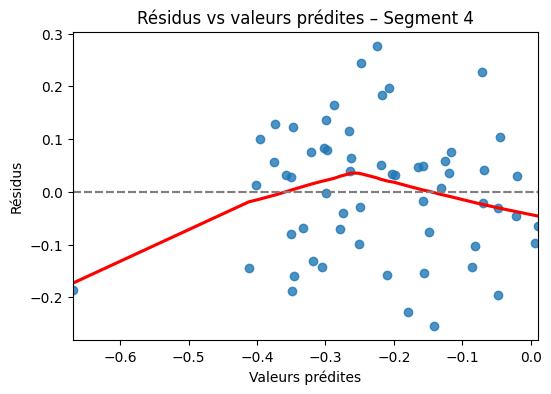

🧪 Jarque-Bera: stat=0.64, p-value=0.7270 → ✅
🧪 Breusch-Pagan p-value=0.4782 → ✅
🧪 Durbin-Watson: 2.06 → ✅

📐 VIF :
                Variable        VIF
0                  const  45.227107
1                    PIB   4.988288
2               PIB_lag1   4.116305
3            PIB_squared   3.177370
4          PIB_Inflation   2.776856
5              TCH_diff1   1.523395
6         TCH_diff1_lag1   1.906542
7        Inflation_diff1   1.598876
8   Inflation_diff1_lag1   1.641450
9           IPL_diff1_hp   1.934048
10          log_CCF_lag1   1.644131
11             PourcNote   4.070241
12     PourcNoteCohorte5   3.012780
📊 MCO – Segment 5 (log + structure + sans colinéarité)
                            OLS Regression Results                            
Dep. Variable:                log_CCF   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     3.160
Date:     

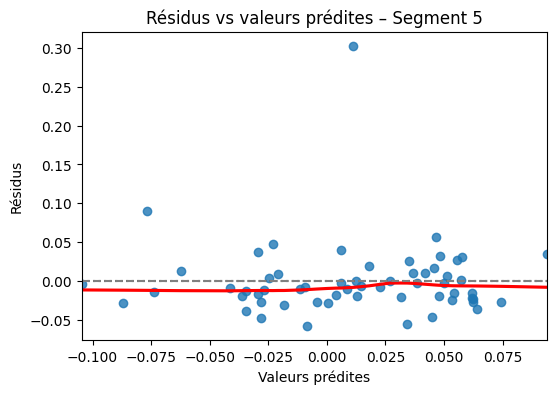

🧪 Jarque-Bera: stat=1484.37, p-value=0.0000 → ❌
🧪 Breusch-Pagan p-value=0.9975 → ✅
🧪 Durbin-Watson: 1.90 → ✅

📐 VIF :
                Variable        VIF
0                  const  91.138832
1                    PIB   5.366737
2               PIB_lag1   4.234648
3            PIB_squared   3.434222
4          PIB_Inflation   2.835793
5              TCH_diff1   1.660110
6         TCH_diff1_lag1   1.920475
7        Inflation_diff1   1.652178
8   Inflation_diff1_lag1   1.578062
9           IPL_diff1_hp   1.619342
10          log_CCF_lag1   1.866782
11             PourcNote  11.411204
12     PourcNoteCohorte5   8.832368


In [53]:
models = {}
for i in range(1, 6):
    models[i] = modele_mco_segment_sans_colinearite(df_merged, note_ref=i)
